In [13]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import imageio.v2 as imageio 
import io
import random
import math

In [14]:
global N, iterations, spiking_activity, V_list, f_target, positions, sizes, colors

    
def init_network(N, reset_potential=-20, size_range = (5,50), sandbox_size=(1000,1000)):
   
    M = np.random.rand(N, N)  # Generate a random connectivity matrix
    M = M / np.sum(M)  # Normalize the matrix
    M = M - np.transpose(M)  # Symmetrically inhibit
    np.fill_diagonal(M,0) # no self-connections

    V = np.random.rand(N)  # Random initial membrane potentials
    spikes = np.random.rand(N) > 0.5  # Random initial spiking states
    V[spikes] = reset_potential  # If a neuron spikes initially, set its potential to -20

    sandbox_width, sandbox_height = sandbox_size

    sizes = np.random.uniform(size_range[0], size_range[1], N)
    positions = np.random.rand(N, 2) * [sandbox_width, sandbox_height]
    colors = ['black' for _ in range(len(positions))]

    
    fig, ax = plt.subplots(figsize=(10,10))
    draw_network(positions, sizes, colors, ax)
    plt.show()
    
    return M, V, positions, sizes, spikes

def draw_network(node_positions, node_sizes, node_colors, ax):
    for loc, size, color in zip(node_positions, node_sizes, node_colors):
        circle = plt.Circle(loc, size, color=color, alpha=0.5)
        ax.add_artist(circle)
        
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 1000)
    ax.set_aspect('equal')
    ax.axis('off')

def get_node_colors(frame):
    colors = []
    for i, s in enumerate(spiking_activity[frame]):
        if s:
            colors.append('green')  # If the neuron is spiking, set color to green
        else:
            # Normalize membrane potential values to range [0, 1] and apply colormap
            voltage_normalized = (V_list[frame, i] - V_list.min()) / (V_list.max() - V_list.min())
            color_rgb = plt.cm.seismic(voltage_normalized)[:3]  # Extract RGB values
            colors.append(color_rgb)  # Append RGB tuple to colors list
    return colors

def get_firing_rates(spiking_activity, window_size):
    
    firing_rates = np.zeros(N)

    for i in range(N):
        firing_rates[i] = np.sum(spiking_activity[i][-window_size:])
    firing_rates /= window_size

    return firing_rates

def check_circle_overlap(positions, sizes):
    overlap_list = []

    for i in range(N):
        for j in range(i+1, N):  # Avoid comparing the same pair twice
            # Calculate the distance between the centers of the circles
            distance = math.sqrt((positions[j][0] - positions[i][0])**2 + (positions[j][1] - positions[i][1])**2)

            # Check if the distance is less than the sum of the radii
            if distance < sizes[i] + sizes[j]:
                overlap_list.append(True)  # Circles overlap
            else:
                overlap_list.append(False)  # Circles don't overlap

    return overlap_list

def adjust_node_sizes(firing_rates, node_sizes, growth_coeff):
    
    for i in range(len(firing_rates)):
        if firing_rates[i] < f_target:
            node_sizes[i] += growth_coeff  # Increase node size
        else:
            node_sizes[i] -= growth_coeff  # Decrease node size
    return node_sizes

In [22]:
def simulate_network(M, V, spikes, iterations, REST=-1, leak=0.001, input_noise=170.5):
    
    N = M.shape[0]
    spiking_activity = []  # List to store spiking states
    V_list = []  # List to store membrane potentials


    for _ in range(iterations):
        V = V + input_noise * np.dot(M, spikes) + 0.1 * (np.random.rand(N) - 0.3) - leak * V
        spikes = (V > 1)  # Neurons spike if their membrane potential exceeds 1
        V[spikes] = REST  # Reset the membrane potential of spiking neurons to the resting potential
        V[V < REST] = REST  # Ensure that membrane potentials do not fall below the resting potential
        spiking_activity.append(spikes.copy())  # Store the spiking states
        V_list.append(V.copy())  # Store the membrane potentials

    spiking_activity = np.array(spiking_activity)  # Convert to numpy array for visualization
    V_list = np.array(V_list)  # Convert to numpy array for visualization
    olist = check_circle_overlap(positions,sizes)
    print(len(olist))
    
    return spiking_activity, V_list

In [10]:
def plot_activity(spiking_activity, V_list):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(spiking_activity.T, aspect='auto', cmap='binary')
    plt.xlabel('Time')
    plt.ylabel('Neuron Index')
    plt.title('Neuron Firings Over Time')

    plt.subplot(1, 2, 2)
    plt.imshow(V_list.T, aspect='auto', cmap='seismic')
    plt.xlabel('Time')
    plt.ylabel('Neuron index')
    plt.title('Membrane Potential Over Time')
    plt.colorbar(label='Membrane Potential')

    plt.tight_layout()
    plt.show()

def generate_animation(f_name = 'animation.gif', duration=0.1):
    # Create the subplot
    fig, ax = plt.subplots()

    # Create a list to store the frames
    frames = []

    # Iterate over each frame and generate it
    for i in range(iterations):

        # Update colors for the current frame
        colors = get_node_colors(i)

        # Clear previous plot
        plt.clf

        # Plot the network with updated node colors
        draw_network(positions, sizes, colors, ax)

        # Convert the current figure to an image
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)

        # Read the image from the buffer and append it to the list of frames
        frames.append(imageio.imread(buf))

    # Save the frames as an animated GIF
    animation_file = f_name
    imageio.mimsave(animation_file, frames, duration=duration)

    plt.close(fig)  # Close the figure to free up memory

    # Display a message indicating the completion of GIF creation
    print(f"Animation saved as '{animation_file}'")


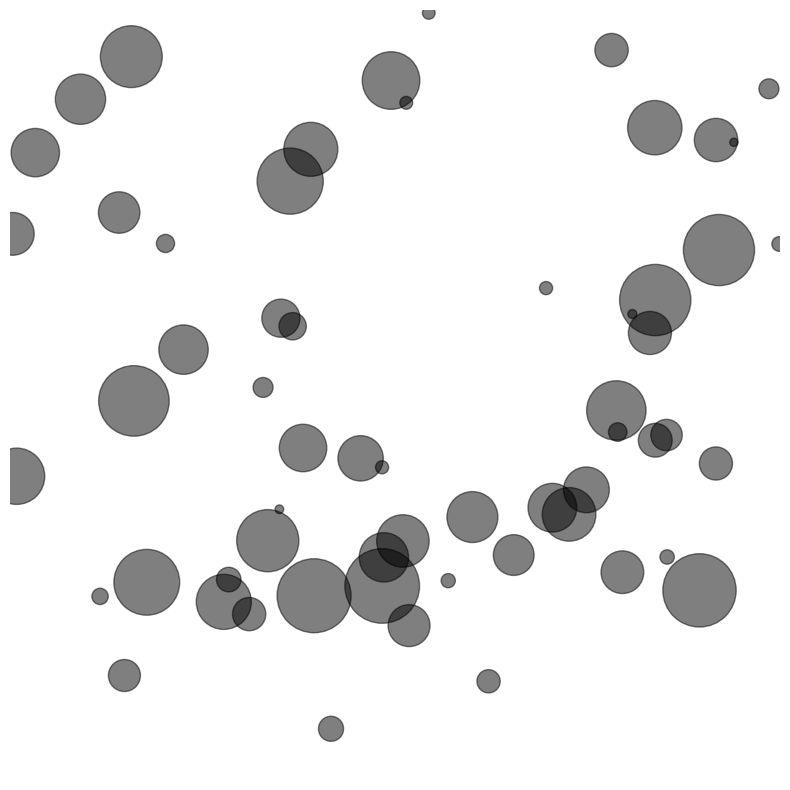

1770


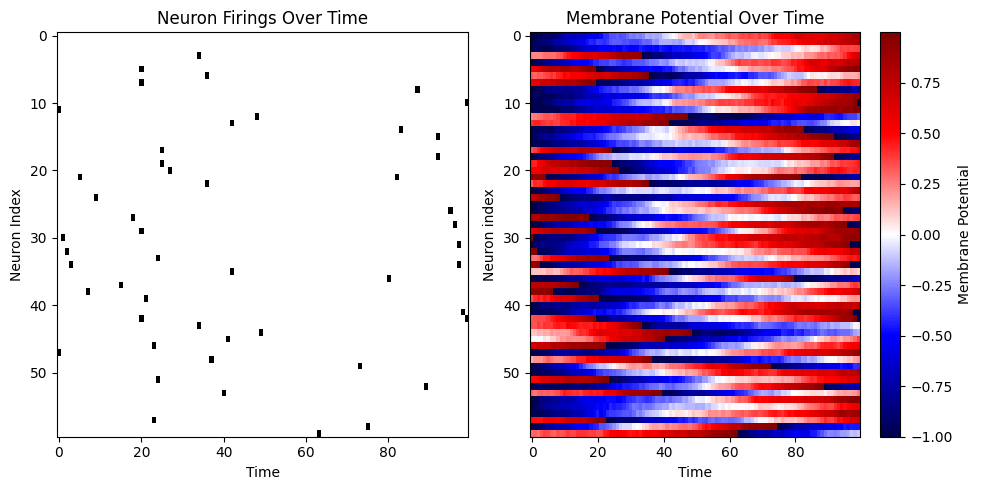

Animation saved as 'test1.gif'


In [23]:
N = 60  
iterations = 100

M, V, positions, sizes, spikes = init_network(N)
spiking_activity, V_list = simulate_network(M, V, spikes, iterations, input_noise = 50)

plot_activity(spiking_activity, V_list)

generate_animation('test1.gif')
